In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 定义要处理的主题
train_subjects = ['Carpenter1', 'Carpenter2', 'Rebar1', 'Rebar2', 'Rebar3']
test_subjects = ['Masonry1', 'Masonry2']

def load_and_preprocess_data(subject, label_mapping):
    """
    加载并预处理指定主题的数据。
    
    参数:
        subject (str): 主题名称
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 处理后的特征X和标签y
    """
    # 读取数据
    df = pd.read_csv(f'../{subject}.csv', low_memory=False)
    
    # 清除空值行
    df_cleaned = df.dropna()
    
    # 转换 'Label_2' 列为数值类型
    df_cleaned.loc[:, 'Label_2'] = pd.to_numeric(df_cleaned['Label_2'], errors='coerce')
    
    # 只选取前八个动作
    df_cleaned = df_cleaned[df_cleaned['Label_2'] <= 8]
    
    # 重新编码标签
    df_cleaned.loc[:, 'Label_2'] = df_cleaned['Label_2'].map(label_mapping)

    # 同步 xd 和 kd 的记录
    df_xd = df_cleaned[df_cleaned['position'] == 'xd'].copy()
    df_kd = df_cleaned[df_cleaned['position'] == 'kd'].copy()

    row_len = min(len(df_xd), len(df_kd))

    # 获取列名并添加后缀以避免重复
    columns_xd = [f'{col}_xd' for col in df_xd.columns]
    columns_kd = [f'{col}_kd' for col in df_kd.columns]

    # 重命名列
    df_xd.columns = columns_xd
    df_kd.columns = columns_kd

    df_xd = df_xd.iloc[:row_len-1, :]
    df_kd = df_kd.iloc[:row_len-1, :]

    df_xd = df_xd.reset_index(drop=True)
    df_kd = df_kd.reset_index(drop=True)

    # 合并两个DataFrame
    paired_df = pd.concat([df_kd, df_xd], axis=1)
    paired_df = paired_df.loc[:, ~paired_df.columns.duplicated()]

    # 删除不需要的列
    columns_to_drop = ['seconds_elapsed_xd','seconds_elapsed_kd', 'position_xd','position_kd', 'time_xd', 'time_kd', 'Real Time_xd', 'Real Time_kd']
    paired_df = paired_df.drop(columns=columns_to_drop)
    
    X = paired_df.drop(['Label_2_xd', 'Label_2_kd', 'Subject_kd', 'Subject_xd'], axis=1)
    y = paired_df['Label_2_xd']

    print(X.columns)

    # 设置窗口大小和步长
    window_size = 30
    step = 15  # 每次滑动窗口移动的步数

    # 创建一个空的DataFrame来存储滑动窗口处理后的结果
    X_rolled_list = []
    y_rolled_list = []

    # 对于X，创建滑动窗口并计算均值
    for i in range(0, len(X) - window_size + 1, step):
        X_window = X.iloc[i:i+window_size].rolling(window=window_size, min_periods=1).mean().iloc[-1]  # 取最后一个值
        X_rolled_list.append(X_window)

    # 对于y，创建滑动窗口并应用模式函数
    for i in range(0, len(y) - window_size + 1, step):
        y_window = y.iloc[i:i+window_size].rolling(window=window_size, min_periods=1).apply(
            lambda x: x.mode().iloc[0] if not x.isnull().all() else None, raw=False
        ).iloc[-1]  # 取最后一个值
        y_rolled_list.append(y_window)

    # 将列表转换为DataFrame/Series
    X_rolled = pd.DataFrame(X_rolled_list, columns=X.columns)
    y_rolled = pd.Series(y_rolled_list)

    # 使用SMOTE处理类别不平衡
    smote = SMOTE(random_state=42)
    X_final, y_final = smote.fit_resample(X_rolled, y_rolled)

    # 将y标签修改成int
    y_final = y_final.astype(int) - 1

    return X_final, y_final

def prepare_datasets(train_subjects, test_subjects, label_mapping):
    """
    准备训练集和测试集。
    
    参数:
        train_subjects (list of str): 训练集主题列表
        test_subjects (list of str): 测试集主题列表
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 训练集特征、训练集标签、测试集特征、测试集标签
    """
    all_train_data = []
    all_test_data = []

    for subject in train_subjects + test_subjects:
        X, y = load_and_preprocess_data(subject, label_mapping)
        if subject in train_subjects:
            all_train_data.append((X, y))
        else:
            all_test_data.append((X, y))

    # 合并所有训练集和测试集数据
    X_train = pd.concat([x for x, _ in all_train_data], axis=0).values
    y_train = pd.concat([y for _, y in all_train_data], axis=0).values
    X_test = pd.concat([x for x, _ in all_test_data], axis=0).values
    y_test = pd.concat([y for _, y in all_test_data], axis=0).values

    return X_train, y_train, X_test, y_test

def plot_confusion_matrix(y_true, y_pred, labels, title, save_path):
    """
    绘制混淆矩阵图。
    
    参数:
        y_true (array-like): 真实标签
        y_pred (array-like): 预测标签
        labels (list of str): 分类标签
        title (str): 图标题
        save_path (str): 保存图片路径
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path, dpi=300)

    # 标签重编码映射
label_mapping = {1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 3, 7: 3, 8: 5}

# 准备数据集
X_train, y_train, X_test, y_test = prepare_datasets(train_subjects, test_subjects, label_mapping)

Index(['Accelerometer.xlsx_z_kd', 'Accelerometer.xlsx_y_kd',
       'Accelerometer.xlsx_x_kd', 'Gravity_z_kd', 'Gravity_y_kd',
       'Gravity_x_kd', 'Gyroscope_z_kd', 'Gyroscope_y_kd', 'Gyroscope_x_kd',
       'Magnetometer_z_kd', 'Magnetometer_y_kd', 'Magnetometer_x_kd', 'yaw_kd',
       'qx_kd', 'qz_kd', 'roll_kd', 'qw_kd', 'qy_kd', 'pitch_kd',
       'Accelerometer.xlsx_z_xd', 'Accelerometer.xlsx_y_xd',
       'Accelerometer.xlsx_x_xd', 'Gravity_z_xd', 'Gravity_y_xd',
       'Gravity_x_xd', 'Gyroscope_z_xd', 'Gyroscope_y_xd', 'Gyroscope_x_xd',
       'Magnetometer_z_xd', 'Magnetometer_y_xd', 'Magnetometer_x_xd', 'yaw_xd',
       'qx_xd', 'qz_xd', 'roll_xd', 'qw_xd', 'qy_xd', 'pitch_xd'],
      dtype='object')
Index(['Accelerometer.xlsx_z_kd', 'Accelerometer.xlsx_y_kd',
       'Accelerometer.xlsx_x_kd', 'Gravity_z_kd', 'Gravity_y_kd',
       'Gravity_x_kd', 'Gyroscope_z_kd', 'Gyroscope_y_kd', 'Gyroscope_x_kd',
       'Magnetometer_z_kd', 'Magnetometer_y_kd', 'Magnetometer_x_kd', 'ya

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def apply_scaling_and_pca(X_train, X_test, n_components):
    """
    对数据进行特征缩放和PCA降维。
    
    参数:
        X_train (array-like): 训练集特征
        X_test (array-like): 测试集特征
        n_components (int): 保留的主成分数量
    
    返回:
        tuple: 缩放和降维后的训练集特征、测试集特征
    """
    # 特征缩放
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # 打印保留的方差百分比
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    print("Total explained variance:", sum(pca.explained_variance_ratio_))
    # 打印降维后的特征维度和名称
    print("Number of components:", X_train_pca.shape[1])


    return X_train_pca, X_test_pca

# 选择要保留的主成分数量，例如保留95%的方差
n_components = 0.95  # 或者你可以直接指定具体的组件数量，比如n_components=10

# 应用特征缩放和PCA
X_train_pca, X_test_pca = apply_scaling_and_pca(X_train, X_test, n_components)

# 现在你可以使用X_train_pca和X_test_pca来训练和评估你的模型了

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# def apply_scaling_and_pca(X_train, X_test, n_components):
#     """
#     对数据进行特征缩放和PCA降维。
    
#     参数:
#         X_train (array-like): 训练集特征
#         X_test (array-like): 测试集特征
#         n_components (int, float, str): 保留的主成分数量或方差百分比，或 "mle" 以使用 MLE 估计
    
#     返回:
#         tuple: 缩放和降维后的训练集特征、测试集特征
#     """
#     # 特征缩放
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # PCA降维
#     if n_components == 'mle':
#         # 使用 MLE 估计最佳的主成分数量
#         pca = PCA(n_components='mle', svd_solver='full')
#     else:
#         # 使用指定的主成分数量或方差百分比
#         pca = PCA(n_components=n_components)
    
#     X_train_pca = pca.fit_transform(X_train_scaled)
#     X_test_pca = pca.transform(X_test_scaled)
    
#     # 打印保留的方差百分比
#     print("Explained variance ratio:", pca.explained_variance_ratio_)
#     print("Total explained variance:", sum(pca.explained_variance_ratio_))
#     # 打印降维后的特征维度
#     print("Number of components:", X_train_pca.shape[1])
    
#     return X_train_pca, X_test_pca

# # 选择要保留的主成分数量，例如保留95%的方差
# n_components = 'mle'  # 或者你可以直接指定具体的组件数量，比如 n_components=10

# # 应用特征缩放和PCA
# X_train_pca, X_test_pca = apply_scaling_and_pca(X_train, X_test, n_components)

# # 现在你可以使用 X_train_pca 和 X_test_pca 来训练和评估你的模型了

Explained variance ratio: [0.11520777 0.09146663 0.07138209 0.06332486 0.05677386 0.04776343
 0.04319633 0.03651374 0.03358195 0.03197382 0.03108817 0.02836172
 0.02815251 0.02649655 0.0247768  0.02361527 0.02314033 0.02253419
 0.02180281 0.021212   0.01882319 0.01860088 0.01700649 0.01577393
 0.01446672 0.01250292 0.0097005  0.00818813]
Total explained variance: 0.9574275909398209
Number of components: 28


In [8]:
from catboost import CatBoostClassifier
from catboost import Pool

# 定义CatBoost参数
catboost_params = {
    'iterations': 500,
    'depth': 4,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'bagging_temperature': 0.9,
    'random_strength': 0.1,
    'one_hot_max_size': 2,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 10,
    'verbose': 0  # 设置verbose为0以减少输出信息
}

catboost_clf = CatBoostClassifier(**catboost_params)

catboost_clf.fit(X_train_pca, y_train, eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)])


In [12]:
y_pred_ = catboost_clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred_)
print(f"Accuracy of the original model: {accuracy:.4f}")

Accuracy of the original model: 0.5387


In [13]:
# 保存原始模型
catboost_clf.save_model('original_model.cbm')

In [14]:
# 加载预训练的模型
pretrained_model = CatBoostClassifier()
pretrained_model.load_model('original_model.cbm')

# 定义新的 CatBoost 分类器
fine_tuned_model = CatBoostClassifier(
    iterations=100,  # 新的迭代次数
    learning_rate=0.05,  # 较小的学习率
    depth=6,
    loss_function='MultiClass',  # 根据你的任务选择合适的损失函数
    random_seed=42,
    verbose=False  # 关闭日志输出
)

# 定义Pool对象
pool = Pool(X_test_pca, label=y_test)

# 使用预训练模型继续训练
fine_tuned_model.fit(
    pool,  # 使用Pool对象
    eval_set=None,  # 如果不需要验证集，可以设置为 None
    init_model=pretrained_model  # 指定预训练模型
)

# 评估模型
y_pred = fine_tuned_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the fine-tuned model: {accuracy:.4f}")


Accuracy of the fine-tuned model: 0.8538


上面的代码已经滑窗，降维，标准化，下面的还没跑

In [6]:
# 保存微调后的模型
fine_tuned_model.save_model('fine_tuned_model.cbm')

In [7]:
feature_label = ['Accelerometer.xlsx_x_kd', 'Accelerometer.xlsx_y_kd',
       'Accelerometer.xlsx_z_kd', 'Gravity_x_kd', 'Gravity_y_kd',
       'Gravity_z_kd', 'Gyroscope_x_kd', 'Gyroscope_y_kd', 'Gyroscope_z_kd',
       'Magnetometer_x_kd', 'Magnetometer_y_kd', 'Magnetometer_z_kd', 'yaw_kd',
       'qx_kd', 'qz_kd', 'roll_kd', 'qw_kd', 'qy_kd', 'pitch_kd',
       'Accelerometer.xlsx_x_xd', 'Accelerometer.xlsx_y_xd',
       'Accelerometer.xlsx_z_xd', 'Gravity_x_xd', 'Gravity_y_xd',
       'Gravity_z_xd', 'Gyroscope_x_xd', 'Gyroscope_y_xd', 'Gyroscope_z_xd',
       'Magnetometer_x_xd', 'Magnetometer_y_xd', 'Magnetometer_z_xd', 'yaw_xd',
       'qx_xd', 'qz_xd', 'roll_xd', 'qw_xd', 'qy_xd', 'pitch_xd']

In [8]:

# 获取特征重要性
feature_importance = fine_tuned_model.get_feature_importance(pool)
# 打印特征重要性
print("Feature Importance:", feature_importance)


feature_label = ['Accelerometer.xlsx_x_kd', 'Accelerometer.xlsx_y_kd',
       'Accelerometer.xlsx_z_kd', 'Gravity_x_kd', 'Gravity_y_kd',
       'Gravity_z_kd', 'Gyroscope_x_kd', 'Gyroscope_y_kd', 'Gyroscope_z_kd',
       'Magnetometer_x_kd', 'Magnetometer_y_kd', 'Magnetometer_z_kd', 'yaw_kd',
       'qx_kd', 'qz_kd', 'roll_kd', 'qw_kd', 'qy_kd', 'pitch_kd',
       'Accelerometer.xlsx_x_xd', 'Accelerometer.xlsx_y_xd',
       'Accelerometer.xlsx_z_xd', 'Gravity_x_xd', 'Gravity_y_xd',
       'Gravity_z_xd', 'Gyroscope_x_xd', 'Gyroscope_y_xd', 'Gyroscope_z_xd',
       'Magnetometer_x_xd', 'Magnetometer_y_xd', 'Magnetometer_z_xd', 'yaw_xd',
       'qx_xd', 'qz_xd', 'roll_xd', 'qw_xd', 'qy_xd', 'pitch_xd']

Feature Importance: [1.11193624e+00 1.16930845e+00 1.57375356e-01 4.91092126e+00
 4.00541296e+00 0.00000000e+00 7.72890279e-01 1.67098546e-01
 7.50768852e-01 1.11346104e+00 2.74784216e+00 1.76069079e+00
 8.31050583e-01 3.49394714e+00 8.55717449e-01 3.60046137e-01
 7.93414001e-01 1.18462970e+00 1.67725704e+01 2.48354450e+00
 5.37685589e+00 1.97074193e+00 1.49970054e+00 2.65379470e+01
 1.72673507e+00 0.00000000e+00 2.19207338e-02 2.99594178e+00
 2.90358022e-01 1.04125758e+00 4.18956832e-01 1.27288896e+00
 4.36980276e-01 9.32037479e-01 1.17648470e-01 1.83051073e+00
 1.58669836e+00 6.50019455e+00]


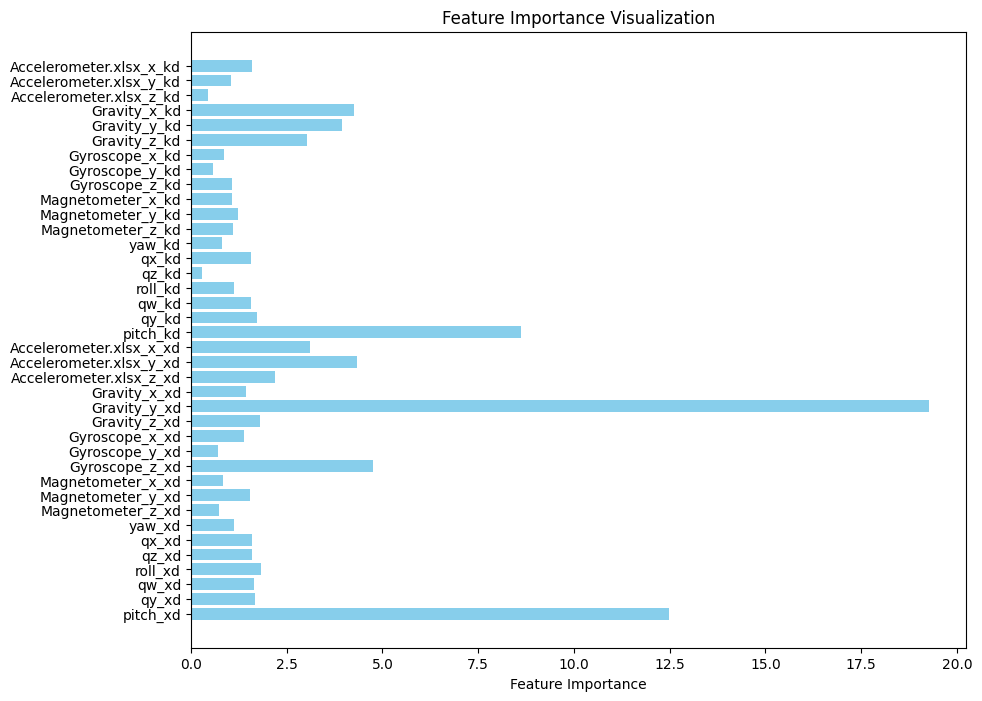

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 特征标签
feature_labels = ['Accelerometer.xlsx_x_kd', 'Accelerometer.xlsx_y_kd',
       'Accelerometer.xlsx_z_kd', 'Gravity_x_kd', 'Gravity_y_kd',
       'Gravity_z_kd', 'Gyroscope_x_kd', 'Gyroscope_y_kd', 'Gyroscope_z_kd',
       'Magnetometer_x_kd', 'Magnetometer_y_kd', 'Magnetometer_z_kd', 'yaw_kd',
       'qx_kd', 'qz_kd', 'roll_kd', 'qw_kd', 'qy_kd', 'pitch_kd',
       'Accelerometer.xlsx_x_xd', 'Accelerometer.xlsx_y_xd',
       'Accelerometer.xlsx_z_xd', 'Gravity_x_xd', 'Gravity_y_xd',
       'Gravity_z_xd', 'Gyroscope_x_xd', 'Gyroscope_y_xd', 'Gyroscope_z_xd',
       'Magnetometer_x_xd', 'Magnetometer_y_xd', 'Magnetometer_z_xd', 'yaw_xd',
       'qx_xd', 'qz_xd', 'roll_xd', 'qw_xd', 'qy_xd', 'pitch_xd']

# 特征重要性
feature_importances = [1.58705639,  1.04404095,  0.4474758,   4.24604875,  3.95314585,  3.02771066,
  0.8745609,   0.5832542,   1.06409514,  1.07145152,  1.22839291,  1.09543153,
  0.81144504,  1.58039332,  0.29134501,  1.12074777,  1.56669477,  1.73226571,
  8.61361923,  3.1223793,   4.33962959,  2.18433951,  1.43680274, 19.26672702,
  1.81368925,  1.38474631,  0.71568254,  4.75533685,  0.83735857,  1.53315088,
  0.72871004,  1.11578747,  1.59938553,  1.59507637,  1.84106137,  1.63909573,
  1.67686492, 12.47500054]

# 创建一个条形图
plt.figure(figsize=(10, 8))
indices = np.arange(len(feature_labels))
plt.barh(indices, feature_importances, color='skyblue')
plt.yticks(indices, feature_labels)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Visualization')
plt.gca().invert_yaxis()  # 反转y轴，使得重要性最高的特征在上方

plt.show()

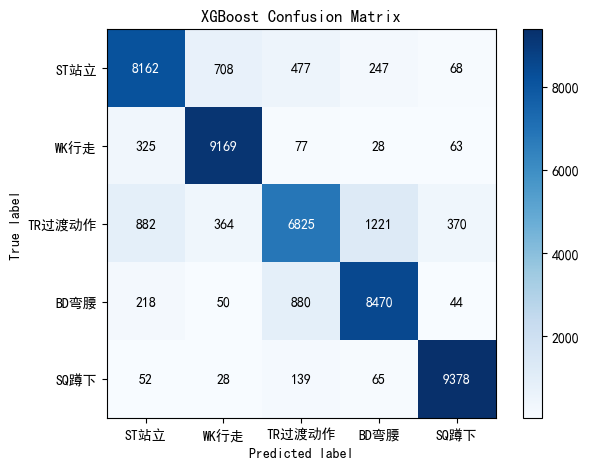

In [13]:
# plt.rcParams['font.sans-serif'] = ['SimHei']
plot_confusion_matrix(y_test, y_pred, ['ST站立', 'WK行走', 'TR过渡动作', 'BD弯腰', 'SQ蹲下'], 'XGBoost Confusion Matrix', 'XGBoost_Conclusion.png')

In [ ]:
feature_label = ['Accelerometer.xlsx_z_kd', 'Accelerometer.xlsx_y_kd',
       'Accelerometer.xlsx_x_kd', 'Gravity_z_kd', 'Gravity_y_kd',
       'Gravity_x_kd', 'Gyroscope_z_kd', 'Gyroscope_y_kd', 'Gyroscope_x_kd',
       'Magnetometer_z_kd', 'Magnetometer_y_kd', 'Magnetometer_x_kd', 'yaw_kd',
       'qx_kd', 'qz_kd', 'roll_kd', 'qw_kd', 'qy_kd', 'pitch_kd', 'Label_2_kd',
       'Accelerometer.xlsx_z_xd', 'Accelerometer.xlsx_y_xd',
       'Accelerometer.xlsx_x_xd', 'Gravity_z_xd', 'Gravity_y_xd',
       'Gravity_x_xd', 'Gyroscope_z_xd', 'Gyroscope_y_xd', 'Gyroscope_x_xd',
       'Magnetometer_z_xd', 'Magnetometer_y_xd', 'Magnetometer_x_xd', 'yaw_xd',
       'qx_xd', 'qz_xd', 'roll_xd', 'qw_xd', 'qy_xd', 'pitch_xd']



In [79]:
pd_X_test = pd.DataFrame(X_test,columns=feature_label)
pd_y_test = pd.DataFrame(y_test,columns=['label'])
pd_X_test

,Accelerometer.xlsx_x_kd,Accelerometer.xlsx_y_kd,Accelerometer.xlsx_z_kd,Gravity_x_kd,Gravity_y_kd,Gravity_z_kd,Gyroscope_x_kd,Gyroscope_y_kd,Gyroscope_z_kd,Magnetometer_x_kd,...,Magnetometer_x_xd,Magnetometer_y_xd,Magnetometer_z_xd,yaw_xd,qx_xd,qz_xd,roll_xd,qw_xd,qy_xd,pitch_xd
0,-0.091652,-0.774333,-0.660728,-9.503858,-2.402024,-0.278098,-0.050011,0.024321,-0.038968,-29.161255,...,16.014099,-57.254448,-11.922226,1.327859,-0.622519,0.088941,-2.773654,-0.294146,0.719748,0.516975
1,0.060492,-0.686571,-0.653882,-9.504345,-2.400154,-0.277612,-0.022849,0.034795,-0.061955,-29.231964,...,15.966461,-57.164082,-11.856413,1.330893,-0.623777,0.088091,-2.769418,-0.296451,0.717808,0.519347
2,0.107479,-0.629816,-0.615768,-9.505319,-2.396305,-0.277469,-0.000554,0.038268,-0.076908,-29.152059,...,15.811198,-57.121332,-11.790099,1.333582,-0.624944,0.087034,-2.764272,-0.299083,0.715810,0.521811
3,0.104225,-0.572532,-0.575404,-9.506404,-2.391864,-0.278503,0.014356,0.036589,-0.085828,-29.093170,...,15.660370,-57.028286,-11.732923,1.336092,-0.626050,0.085833,-2.758985,-0.301667,0.713881,0.523973
4,0.069106,-0.502790,-0.522788,-9.507378,-2.387640,-0.281335,0.027380,0.031228,-0.089959,-29.062024,...,15.544727,-56.955111,-11.640393,1.338646,-0.627118,0.084881,-2.754874,-0.303752,0.712154,0.525857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724685,-0.038321,-0.005872,-0.032085,-8.679791,0.317955,-4.552861,0.022313,-0.009104,0.031678,-67.458170,...,13.739581,-62.007430,11.428153,2.453934,0.863634,-0.105343,-2.622607,0.394086,-0.293771,0.837863
724686,-0.044622,0.005325,-0.107455,-8.982932,0.678085,-3.874415,0.024398,-0.013121,0.040384,-64.172612,...,12.430217,-61.862004,15.485755,2.526997,0.868361,-0.135228,-0.241851,0.378246,-0.283059,0.826277
724687,-0.056169,-0.009270,-0.029575,-8.677475,0.289014,-4.559407,0.002525,-0.006057,-0.002437,-67.695193,...,10.823439,-55.190448,35.809353,2.939377,0.899517,-0.202923,2.780474,0.352542,-0.159373,0.773888
724688,-0.051267,-0.012225,-0.030834,-8.727993,1.045069,-4.347447,0.004445,-0.001617,-0.003318,-65.380931,...,15.683735,-60.915648,20.152154,2.587072,0.885025,-0.163628,3.000162,0.334919,-0.278889,0.753352
